<a href="https://colab.research.google.com/github/remimomo/test-repo/blob/master/delay_prediction_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import pandas as pd
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import classification_report
import joblib

# Load the datasets
shipment_bookings = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Shipment_bookings.csv')
gps_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/GPS_data.csv')
new_bookings = pd.read_csv('/content/drive/My Drive/Colab Notebooks/New_bookings.csv')

# Haversine function to calculate the distance between two latitude-longitude points
def haversine(lat1, lon1, lat2, lon2):
    from math import radians, cos, sin, sqrt, atan2

    # Radius of the Earth in kilometers
    R = 6371.0

    # Convert latitude and longitude from degrees to radians
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)

    # Haversine formula to calculate the distance
    a = sin(dlat / 2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c

    return distance

# Step 1: Convert relevant columns to datetime format
# This is necessary to perform date-based operations accurately
shipment_bookings['FIRST_COLLECTION_SCHEDULE_EARLIEST'] = pd.to_datetime(shipment_bookings['FIRST_COLLECTION_SCHEDULE_EARLIEST'])
shipment_bookings['FIRST_COLLECTION_SCHEDULE_LATEST'] = pd.to_datetime(shipment_bookings['FIRST_COLLECTION_SCHEDULE_LATEST'])
shipment_bookings['LAST_DELIVERY_SCHEDULE_EARLIEST'] = pd.to_datetime(shipment_bookings['LAST_DELIVERY_SCHEDULE_EARLIEST'])
shipment_bookings['LAST_DELIVERY_SCHEDULE_LATEST'] = pd.to_datetime(shipment_bookings['LAST_DELIVERY_SCHEDULE_LATEST'])
gps_data['RECORD_TIMESTAMP'] = pd.to_datetime(gps_data['RECORD_TIMESTAMP'])

# Filter shipments within the specified time period (October 1, 2023 - December 31, 2023)
start_date = pd.Timestamp("2023-10-1", tz="UTC").replace(microsecond=0)
end_date = pd.Timestamp("2023-12-31", tz="UTC").replace(microsecond=0)
#end_date = start_date - pd.Timedelta(days=90)
filtered_shipments = shipment_bookings[
    (shipment_bookings['LAST_DELIVERY_SCHEDULE_EARLIEST'] >= start_date) &
    (shipment_bookings['LAST_DELIVERY_SCHEDULE_LATEST'] <= end_date)
]

# Merge GPS data with filtered shipments on SHIPMENT_NUMBER
merged_data = pd.merge(filtered_shipments, gps_data, on='SHIPMENT_NUMBER', how='left')

# Determine the actual delivery times by finding the last GPS record for each shipment
actual_delivery_times = merged_data.groupby('SHIPMENT_NUMBER')['RECORD_TIMESTAMP'].max().reset_index()

# Merge actual delivery times back with the filtered shipments
delivery_analysis = pd.merge(filtered_shipments, actual_delivery_times, on='SHIPMENT_NUMBER', how='left')
delivery_analysis.rename(columns={'RECORD_TIMESTAMP': 'ACTUAL_DELIVERY_TIME'}, inplace=True)

# Calculate the on-time delivery status
delivery_analysis['ON_TIME'] = delivery_analysis['ACTUAL_DELIVERY_TIME'] <= (delivery_analysis['LAST_DELIVERY_SCHEDULE_LATEST'] + timedelta(minutes=30))

# Feature Engineering: Calculate delivery window duration and distance
delivery_analysis['DELIVERY_WINDOW'] = (delivery_analysis['LAST_DELIVERY_SCHEDULE_LATEST'] - delivery_analysis['LAST_DELIVERY_SCHEDULE_EARLIEST']).dt.total_seconds() / 3600
delivery_analysis['DISTANCE'] = delivery_analysis.apply(lambda row: haversine(row['FIRST_COLLECTION_LATITUDE'], row['FIRST_COLLECTION_LONGITUDE'], row['LAST_DELIVERY_LATITUDE'], row['LAST_DELIVERY_LONGITUDE']), axis=1)

# Prepare the feature set and target variable
features = ['VEHICLE_SIZE', 'VEHICLE_BUILD_UP', 'DELIVERY_WINDOW', 'DISTANCE', 'SHIPMENT_NUMBER', 'CARRIER_DISPLAY_ID']
Xt = delivery_analysis[features]
y = delivery_analysis['ON_TIME']

# Encode categorical features
Xe = pd.get_dummies(Xt, columns=['VEHICLE_SIZE', 'VEHICLE_BUILD_UP', 'SHIPMENT_NUMBER', 'CARRIER_DISPLAY_ID'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(Xe, y, test_size=0.2, train_size=0.8, random_state=42)

# Train a RandomForestClassifier
#model = RandomForestClassifier(n_estimators=100, random_state=42)
model = RandomForestClassifier(n_estimators = 100,
                           random_state = 42,
                           min_samples_split = 10,
                           max_features = "sqrt",
                           bootstrap = True)

model.fit(X_train, y_train)

# Predict on the test set and evaluate the model's performance
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Save the trained model
joblib.dump(model, 'model.pkl')

# Step 4: Predict delays for new bookings
# Prepare the new bookings dataset similarly to the training set
X_new = pd.get_dummies(new_bookings, columns=['VEHICLE_SIZE', 'VEHICLE_BUILD_UP', 'SHIPMENT_NUMBER', 'CARRIER_DISPLAY_ID'])

# Ensure the new data has the same structure as the training data
X_new = X_new.reindex(columns=Xe.columns, fill_value=0)

# Predict the likelihood of delay for the new bookings
new_bookings['delay_likelihood'] = model.predict(X_new)

# Display the predictions for new bookings
print("Predictions for new bookings:")
print(new_bookings[['SHIPMENT_NUMBER', 'delay_likelihood']])


<ipython-input-9-b97c2ebc38cd>:38: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  gps_data['RECORD_TIMESTAMP'] = pd.to_datetime(gps_data['RECORD_TIMESTAMP'])


Accuracy: 0.69

Classification Report:
              precision    recall  f1-score   support

       False       0.64      0.34      0.45       237
        True       0.70      0.89      0.78       410

    accuracy                           0.69       647
   macro avg       0.67      0.62      0.62       647
weighted avg       0.68      0.69      0.66       647

Predictions for new bookings:
          SHIPMENT_NUMBER  delay_likelihood
0    SEZHUK-240118-283413              True
1    SEZHUK-240111-281159             False
2    SEZHUK-240110-280958              True
3    SEZHUK-240115-282151              True
4    SEZHUK-240110-280768              True
..                    ...               ...
995  SEZHUK-240111-281068              True
996  SEZHUK-240111-281152              True
997  SEZHUK-240116-282583              True
998  SEZHUK-240102-278172              True
999  SEZHUK-240109-280509              True

[1000 rows x 2 columns]


In [ ]:
list(new_bookings)

['SHIPMENT_NUMBER',
 'SHIPPER_ID',
 'CARRIER_DISPLAY_ID',
 'VEHICLE_SIZE',
 'VEHICLE_BUILD_UP',
 'FIRST_COLLECTION_POST_CODE',
 'LAST_DELIVERY_POST_CODE',
 'FIRST_COLLECTION_LATITUDE',
 'FIRST_COLLECTION_LONGITUDE',
 'LAST_DELIVERY_LATITUDE',
 'LAST_DELIVERY_LONGITUDE',
 'FIRST_COLLECTION_SCHEDULE_EARLIEST',
 'FIRST_COLLECTION_SCHEDULE_LATEST',
 'LAST_DELIVERY_SCHEDULE_EARLIEST',
 'LAST_DELIVERY_SCHEDULE_LATEST',
 'delay_likelihood']

In [ ]:
list(X_new)

['DELIVERY_WINDOW',
 'DISTANCE',
 'VEHICLE_SIZE_18T Rigid',
 'VEHICLE_SIZE_26T Rigid',
 'VEHICLE_SIZE_3.5 T Van',
 'VEHICLE_SIZE_3.5T Van',
 'VEHICLE_SIZE_7.5T Rigid',
 'VEHICLE_SIZE_Tractor Unit',
 'VEHICLE_BUILD_UP_20ft Container',
 'VEHICLE_BUILD_UP_40ft Container',
 'VEHICLE_BUILD_UP_Box',
 'VEHICLE_BUILD_UP_Box 40ft',
 'VEHICLE_BUILD_UP_Box 44ft',
 'VEHICLE_BUILD_UP_Curtain Side',
 'VEHICLE_BUILD_UP_Curtain-Side 13.6M Trailer',
 'VEHICLE_BUILD_UP_Double Deck Trailer',
 'VEHICLE_BUILD_UP_High Security',
 'VEHICLE_BUILD_UP_LWB Van',
 'VEHICLE_BUILD_UP_Temperature-Controlled',
 'VEHICLE_BUILD_UP_Tractor Only',
 'VEHICLE_BUILD_UP_Tractor Only 6x2',
 'SHIPMENT_NUMBER_SEZHUK-230918-245388',
 'SHIPMENT_NUMBER_SEZHUK-230919-245487',
 'SHIPMENT_NUMBER_SEZHUK-230919-245488',
 'SHIPMENT_NUMBER_SEZHUK-230919-245489',
 'SHIPMENT_NUMBER_SEZHUK-230919-245490',
 'SHIPMENT_NUMBER_SEZHUK-230919-245491',
 'SHIPMENT_NUMBER_SEZHUK-230919-245493',
 'SHIPMENT_NUMBER_SEZHUK-230919-245494',
 'SHIPMENT_NUM

In [ ]:
new_bookings.head()

,SHIPMENT_NUMBER,SHIPPER_ID,CARRIER_ID,VEHICLE_SIZE,VEHICLE_BUILD_UP,FIRST_COLLECTION_POST_CODE,LAST_DELIVERY_POST_CODE,FIRST_COLLECTION_LATITUDE,FIRST_COLLECTION_LONGITUDE,LAST_DELIVERY_LATITUDE,LAST_DELIVERY_LONGITUDE,FIRST_COLLECTION_SCHEDULE_EARLIEST,FIRST_COLLECTION_SCHEDULE_LATEST,LAST_DELIVERY_SCHEDULE_EARLIEST,LAST_DELIVERY_SCHEDULE_LATEST
0,SEZHUK-240118-283413,ee7cbc7b-4f14-44ac-9c6e-086d70a27141,CAUK000872,Tractor Unit,Box,DUBLIN,DN3 3FF,53.407411,-6.238118,53.537912,-1.033570,2024-01-18T18:00:00.000Z,2024-01-18T23:00:00.000Z,2024-01-19T12:00:00.000Z,2024-01-19T13:00:00.000Z
1,SEZHUK-240111-281159,192cd5b5-978c-4681-b206-2f4d04e081ec,CAUK000876,Tractor Unit,Curtain-Side 13.6M Trailer,LS24 9SD,BT26 6JJ,53.882244,-1.267537,54.474078,-6.104285,2024-01-12T10:00:00.000Z,2024-01-16T07:00:00.000Z,2024-01-16T07:30:00.000Z,2024-01-16T08:00:00.000Z
2,SEZHUK-240110-280958,ee7cbc7b-4f14-44ac-9c6e-086d70a27141,CAUK000872,Tractor Unit,Curtain-Side 13.6M Trailer,DUBLIN,DN3 3FF,53.407411,-6.238118,53.537912,-1.033570,2024-01-11T15:03:00.000Z,2024-01-11T15:33:00.000Z,2024-01-12T14:33:00.000Z,2024-01-12T15:03:00.000Z
3,SEZHUK-240115-282151,3244246f-e37c-4ba4-b9b3-61416a4449ae,CAUK000250,Tractor Unit,Curtain-Side 13.6M Trailer,S80 3FY,DUBLIN,53.293393,-1.074008,53.294121,-6.441900,2024-01-16T06:00:00.000Z,2024-01-16T06:59:00.000Z,2024-01-18T11:01:00.000Z,2024-01-18T11:31:00.000Z
4,SEZHUK-240110-280768,3244246f-e37c-4ba4-b9b3-61416a4449ae,CAUK000250,Tractor Unit,Curtain-Side 13.6M Trailer,S80 3FY,BT36 7LQ,53.293393,-1.074008,54.664518,-5.932184,2024-01-11T06:00:00.000Z,2024-01-11T06:59:00.000Z,2024-01-15T07:25:00.000Z,2024-01-15T07:55:00.000Z


Missing Values:
 PROJECT_ID                            0
SHIPMENT_NUMBER                       0
CARRIER_DISPLAY_ID                    0
VEHICLE_SIZE                          0
VEHICLE_BUILD_UP                      0
FIRST_COLLECTION_POST_CODE            1
LAST_DELIVERY_POST_CODE               4
FIRST_COLLECTION_LATITUDE             0
FIRST_COLLECTION_LONGITUDE            0
LAST_DELIVERY_LATITUDE                0
LAST_DELIVERY_LONGITUDE               0
FIRST_COLLECTION_SCHEDULE_EARLIEST    0
FIRST_COLLECTION_SCHEDULE_LATEST      0
LAST_DELIVERY_SCHEDULE_EARLIEST       0
LAST_DELIVERY_SCHEDULE_LATEST         0
dtype: int64
Number of duplicate rows: 0
Summary Statistics:
        FIRST_COLLECTION_LATITUDE  FIRST_COLLECTION_LONGITUDE  \
count                3240.000000                 3240.000000   
mean                   53.001145                   -1.581723   
std                     0.854847                    0.879254   
min                    50.386450                   -6.104285   
2

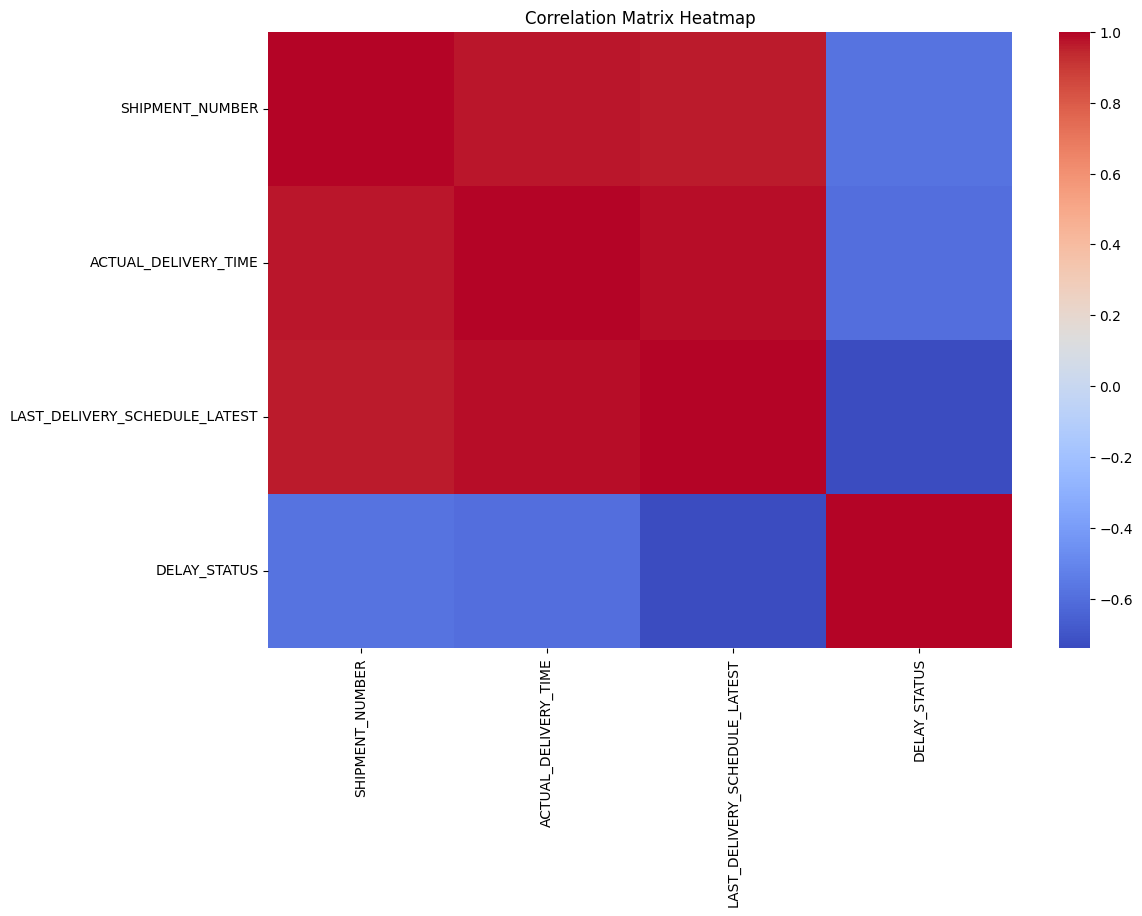

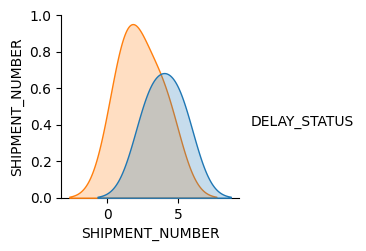

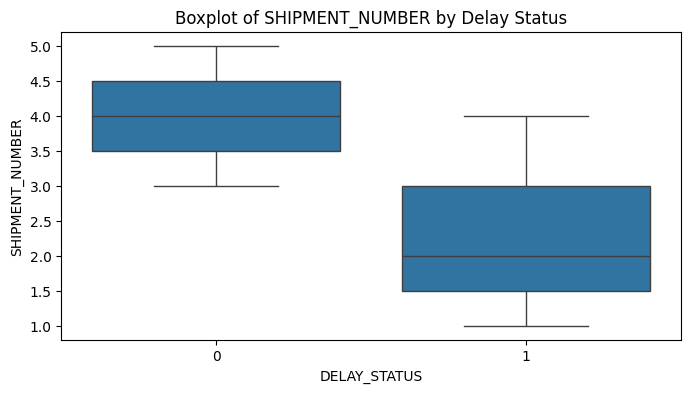

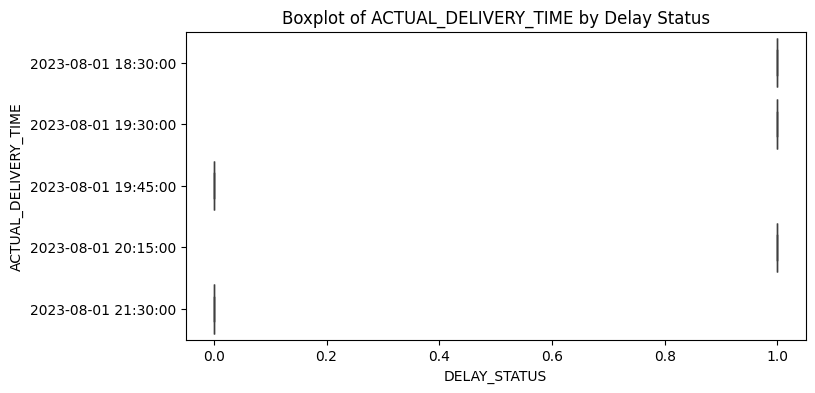

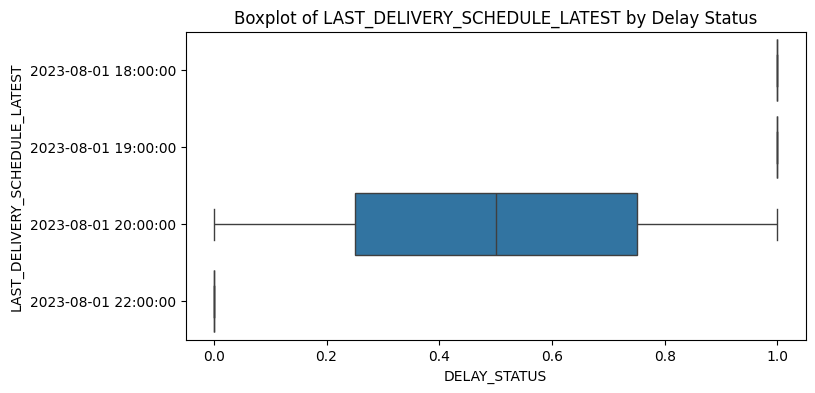

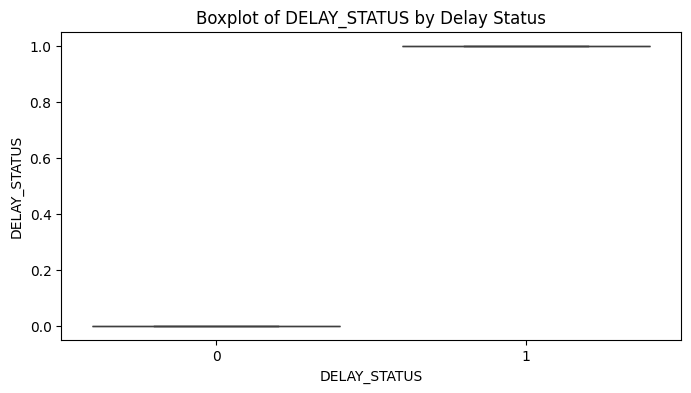

<ipython-input-4-4cf6615d9d7c>:142: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  gps_data['RECORD_TIMESTAMP'] = pd.to_datetime(gps_data['RECORD_TIMESTAMP'])


NameError: name 'y_pred' is not defined

In [4]:
############################### EXPLORATORY DATA ANALYSES ############################
###########1. Load the Data ############
import pandas as pd
import numpy as np

# Load the dataset
# Assuming the dataset is named 'shipment_data.csv' for this analysis
shipment_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Shipment_bookings.csv')
#shipment_data = pd.read_csv('/Data/Shipment_bookings.csv')

# Display the first few rows to understand the structure
shipment_data.head()

########### 2. Data Cleaning ############
# Check for missing values
missing_values = shipment_data.isnull().sum()
print("Missing Values:\n", missing_values)

# If there are missing values, decide how to handle them
# For example, fill with median or mode, or drop if appropriate
shipment_data = shipment_data.dropna()  # For simplicity, let's drop missing values

# Check for duplicates
duplicates = shipment_data.duplicated().sum()
print("Number of duplicate rows:", duplicates)

# If duplicates exist, remove them
shipment_data = shipment_data.drop_duplicates()

# Convert date columns to datetime format for easier manipulation
shipment_data['FIRST_COLLECTION_SCHEDULE_EARLIEST'] = pd.to_datetime(shipment_data['FIRST_COLLECTION_SCHEDULE_EARLIEST'])
shipment_data['LAST_DELIVERY_SCHEDULE_LATEST'] = pd.to_datetime(shipment_data['LAST_DELIVERY_SCHEDULE_LATEST'])

########## 3. Descriptive Statistics ##########
# Get summary statistics for numerical columns
summary_statistics = shipment_data.describe()
print("Summary Statistics:\n", summary_statistics)

# Get summary statistics for categorical columns
categorical_summary = shipment_data.describe(include=['object'])
print("Categorical Summary:\n", categorical_summary)

# Identify the target variable (e.g., delay status, if exists in the dataset)
# Assuming the target variable is 'DELAY_STATUS' with 0 = On Time, 1 = Delayed

########## 4. Correlation Analysis ##########
import pandas as pd

# Assuming the dataset includes an actual delivery time column, 'ACTUAL_DELIVERY_TIME'
# If not present, we would need to merge GPS data or equivalent to get this column.

# Example dataset with 'ACTUAL_DELIVERY_TIME' and 'LAST_DELIVERY_SCHEDULE_LATEST'
# For this example, I will create a small DataFrame to demonstrate
data = {
    'SHIPMENT_NUMBER': [1, 2, 3, 4, 5],
    'ACTUAL_DELIVERY_TIME': pd.to_datetime([
        '2023-08-01 18:30', '2023-08-01 19:30', '2023-08-01 19:45', '2023-08-01 20:15', '2023-08-01 21:30'
    ]),
    'LAST_DELIVERY_SCHEDULE_LATEST': pd.to_datetime([
        '2023-08-01 18:00', '2023-08-01 19:00', '2023-08-01 20:00', '2023-08-01 20:00', '2023-08-01 22:00'
    ])
}

shipment_data = pd.DataFrame(data)

# Calculate DELAY_STATUS: 0 for On Time, 1 for Delayed
shipment_data['DELAY_STATUS'] = (shipment_data['ACTUAL_DELIVERY_TIME'] > shipment_data['LAST_DELIVERY_SCHEDULE_LATEST']).astype(int)

# Display the DataFrame to show the DELAY_STATUS calculation
shipment_data

# Convert categorical variables to numerical for correlation analysis
# Using one-hot encoding for categorical variables
shipment_data_encoded = pd.get_dummies(shipment_data, drop_first=True)

# Calculate the correlation matrix
correlation_matrix = shipment_data_encoded.corr()

# Display the correlation matrix for the target variable 'DELAY_STATUS'
correlation_with_delay = correlation_matrix['DELAY_STATUS'].sort_values(ascending=False)
print("Correlation with Delay Status:\n", correlation_with_delay)

########## 5. Visualisation ##########
import seaborn as sns
import matplotlib.pyplot as plt

# Heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

# Pairplot to visualize relationships between variables
sns.pairplot(shipment_data, hue='DELAY_STATUS')
plt.show()

# Boxplot for each feature by 'DELAY_STATUS'
for column in shipment_data.columns:
    if shipment_data[column].dtype != 'object':
        plt.figure(figsize=(8, 4))
        sns.boxplot(x='DELAY_STATUS', y=column, data=shipment_data)
        plt.title(f'Boxplot of {column} by Delay Status')
        plt.show()

########## 6. Feature Importance using RandomForest #########
import pandas as pd
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import classification_report
import joblib

# Load the datasets
shipment_bookings = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Shipment_bookings.csv')
gps_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/GPS_data.csv')
new_bookings = pd.read_csv('/content/drive/My Drive/Colab Notebooks/New_bookings.csv')

# Haversine function to calculate the distance between two latitude-longitude points
def haversine(lat1, lon1, lat2, lon2):
    from math import radians, cos, sin, sqrt, atan2

    # Radius of the Earth in kilometers
    R = 6371.0

    # Convert latitude and longitude from degrees to radians
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)

    # Haversine formula to calculate the distance
    a = sin(dlat / 2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c

    return distance

# Step 1: Convert relevant columns to datetime format
# This is necessary to perform date-based operations accurately
shipment_bookings['FIRST_COLLECTION_SCHEDULE_EARLIEST'] = pd.to_datetime(shipment_bookings['FIRST_COLLECTION_SCHEDULE_EARLIEST'])
shipment_bookings['FIRST_COLLECTION_SCHEDULE_LATEST'] = pd.to_datetime(shipment_bookings['FIRST_COLLECTION_SCHEDULE_LATEST'])
shipment_bookings['LAST_DELIVERY_SCHEDULE_EARLIEST'] = pd.to_datetime(shipment_bookings['LAST_DELIVERY_SCHEDULE_EARLIEST'])
shipment_bookings['LAST_DELIVERY_SCHEDULE_LATEST'] = pd.to_datetime(shipment_bookings['LAST_DELIVERY_SCHEDULE_LATEST'])
gps_data['RECORD_TIMESTAMP'] = pd.to_datetime(gps_data['RECORD_TIMESTAMP'])

# Filter shipments within the specified time period (October 1, 2023 - December 31, 2023)
start_date = pd.Timestamp("2023-10-1", tz="UTC").replace(microsecond=0)
end_date = pd.Timestamp("2023-12-31", tz="UTC").replace(microsecond=0)
#end_date = start_date - pd.Timedelta(days=90)
filtered_shipments = shipment_bookings[
    (shipment_bookings['LAST_DELIVERY_SCHEDULE_EARLIEST'] >= start_date) &
    (shipment_bookings['LAST_DELIVERY_SCHEDULE_LATEST'] <= end_date)
]

# Merge GPS data with filtered shipments on SHIPMENT_NUMBER
merged_data = pd.merge(filtered_shipments, gps_data, on='SHIPMENT_NUMBER', how='left')

# Determine the actual delivery times by finding the last GPS record for each shipment
actual_delivery_times = merged_data.groupby('SHIPMENT_NUMBER')['RECORD_TIMESTAMP'].max().reset_index()

# Merge actual delivery times back with the filtered shipments
delivery_analysis = pd.merge(filtered_shipments, actual_delivery_times, on='SHIPMENT_NUMBER', how='left')
delivery_analysis.rename(columns={'RECORD_TIMESTAMP': 'ACTUAL_DELIVERY_TIME'}, inplace=True)

# Calculate the on-time delivery status
delivery_analysis['ON_TIME'] = delivery_analysis['ACTUAL_DELIVERY_TIME'] <= (delivery_analysis['LAST_DELIVERY_SCHEDULE_LATEST'] + timedelta(minutes=30))

# Feature Engineering: Calculate delivery window duration and distance
delivery_analysis['DELIVERY_WINDOW'] = (delivery_analysis['LAST_DELIVERY_SCHEDULE_LATEST'] - delivery_analysis['LAST_DELIVERY_SCHEDULE_EARLIEST']).dt.total_seconds() / 3600
delivery_analysis['DISTANCE'] = delivery_analysis.apply(lambda row: haversine(row['FIRST_COLLECTION_LATITUDE'], row['FIRST_COLLECTION_LONGITUDE'], row['LAST_DELIVERY_LATITUDE'], row['LAST_DELIVERY_LONGITUDE']), axis=1)

# Prepare the feature set and target variable
features = ['VEHICLE_SIZE', 'VEHICLE_BUILD_UP', 'DELIVERY_WINDOW', 'DISTANCE', 'SHIPMENT_NUMBER', 'CARRIER_DISPLAY_ID']
Xt = delivery_analysis[features]
y = delivery_analysis['ON_TIME']

# Encode categorical features
Xe = pd.get_dummies(Xt, columns=['VEHICLE_SIZE', 'VEHICLE_BUILD_UP', 'SHIPMENT_NUMBER', 'CARRIER_DISPLAY_ID'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(Xe, y, test_size=0.2, train_size=0.8, random_state=42)

# Train a RandomForestClassifier
#model = RandomForestClassifier(n_estimators=100, random_state=42)
model = RandomForestClassifier(n_estimators = 100,
                           random_state = 42,
                           min_samples_split = 10,
                           max_features = "sqrt",
                           bootstrap = True)

model.fit(X_train, y_train)

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))

# Get feature importances
feature_importances = model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': Xe.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("Feature Importances:\n", importance_df)

# Plotting feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance from RandomForest')
plt.show()

# Summarizing the results in a DataFrame for clarity
results_summary = pd.DataFrame({
    'Step': ['Data Cleaning', 'Descriptive Statistics', 'Correlation Analysis', 'Feature Importance Analysis'],
    'Details': [
        'Handled missing values and duplicates; converted date columns.',
        'Generated summary statistics for both numerical and categorical variables.',
        'Calculated correlation matrix; identified features correlated with delay.',
        'Used RandomForest to identify and rank the most important features.'
    ]
})

print("Summary of Exploratory Data Analysis:\n", results_summary)

############################# Plot of correlation between different factors and delays ##########################

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data to simulate correlation between factors and delays
data = {
    'Weather_Severity': [0.2, 0.3, 0.5, 0.4, 0.6],
    'Traffic_Condition': [0.4, 0.5, 0.7, 0.3, 0.8],
    'Vehicle_Type': [0.3, 0.2, 0.4, 0.6, 0.7],
    'Delay': [0, 1, 1, 0, 1]  # Binary outcome: 1 for delay, 0 for on-time
}

df = pd.DataFrame(data)

# Compute the correlation matrix
corr_matrix = df.corr()

# Plotting side-by-side: Bar chart and heatmap
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Bar chart showing correlation with delay
corr_with_delay = corr_matrix['Delay'].drop('Delay')
axes[0].bar(corr_with_delay.index, corr_with_delay.values, color='skyblue')
axes[0].set_title('Correlation Between Factors and Delay')
axes[0].set_ylabel('Correlation Value')
axes[0].set_ylim(-1, 1)

# Heatmap of the entire correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[1])
axes[1].set_title('Heatmap of Correlations')

# Show the plot
plt.tight_layout()
plt.show()

In [2]:
###########1. Load the Data ############
import pandas as pd
import numpy as np

# Load the dataset
# Assuming the dataset is named 'shipment_data.csv' for this analysis
shipment_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Shipment_bookings.csv')

# Display the first few rows to understand the structure
shipment_data.head()

########### 2. Data Cleaning ############
# Check for missing values
missing_values = shipment_data.isnull().sum()
print("Missing Values:\n", missing_values)

# If there are missing values, decide how to handle them
# For example, fill with median or mode, or drop if appropriate
shipment_data = shipment_data.dropna()  # For simplicity, let's drop missing values

# Check for duplicates
duplicates = shipment_data.duplicated().sum()
print("Number of duplicate rows:", duplicates)

# If duplicates exist, remove them
shipment_data = shipment_data.drop_duplicates()

# Convert date columns to datetime format for easier manipulation
shipment_data['FIRST_COLLECTION_SCHEDULE_EARLIEST'] = pd.to_datetime(shipment_data['FIRST_COLLECTION_SCHEDULE_EARLIEST'])
shipment_data['LAST_DELIVERY_SCHEDULE_LATEST'] = pd.to_datetime(shipment_data['LAST_DELIVERY_SCHEDULE_LATEST'])

Missing Values:
 PROJECT_ID                            0
SHIPMENT_NUMBER                       0
CARRIER_DISPLAY_ID                    0
VEHICLE_SIZE                          0
VEHICLE_BUILD_UP                      0
FIRST_COLLECTION_POST_CODE            1
LAST_DELIVERY_POST_CODE               4
FIRST_COLLECTION_LATITUDE             0
FIRST_COLLECTION_LONGITUDE            0
LAST_DELIVERY_LATITUDE                0
LAST_DELIVERY_LONGITUDE               0
FIRST_COLLECTION_SCHEDULE_EARLIEST    0
FIRST_COLLECTION_SCHEDULE_LATEST      0
LAST_DELIVERY_SCHEDULE_EARLIEST       0
LAST_DELIVERY_SCHEDULE_LATEST         0
dtype: int64
Number of duplicate rows: 0


In [3]:
########## 3. Descriptive Statistics ##########
# Get summary statistics for numerical columns
summary_statistics = shipment_data.describe()
print("Summary Statistics:\n", summary_statistics)

# Get summary statistics for categorical columns
categorical_summary = shipment_data.describe(include=['object'])
print("Categorical Summary:\n", categorical_summary)

# Identify the target variable (e.g., delay status, if exists in the dataset)
# Assuming the target variable is 'DELAY_STATUS' with 0 = On Time, 1 = Delayed


Summary Statistics:
        FIRST_COLLECTION_LATITUDE  FIRST_COLLECTION_LONGITUDE  \
count                3240.000000                 3240.000000   
mean                   53.001145                   -1.581723   
std                     0.854847                    0.879254   
min                    50.386450                   -6.104285   
25%                    52.322617                   -2.120660   
50%                    53.304842                   -1.630808   
75%                    53.634051                   -1.074008   
max                    55.932081                    1.397815   

       LAST_DELIVERY_LATITUDE  LAST_DELIVERY_LONGITUDE  
count             3240.000000              3240.000000  
mean                52.466500                -1.511175  
std                  1.100276                 1.569985  
min                 50.228709                -8.687242  
25%                 51.557049                -1.983264  
50%                 52.371658                -1.231993  
75%

In [5]:
########## 4. Correlation Analysis ##########
import pandas as pd

# Assuming the dataset includes an actual delivery time column, 'ACTUAL_DELIVERY_TIME'
# If not present, we would need to merge GPS data or equivalent to get this column.

# Example dataset with 'ACTUAL_DELIVERY_TIME' and 'LAST_DELIVERY_SCHEDULE_LATEST'
# For this example, I will create a small DataFrame to demonstrate
data = {
    'SHIPMENT_NUMBER': [1, 2, 3, 4, 5],
    'ACTUAL_DELIVERY_TIME': pd.to_datetime([
        '2023-08-01 18:30', '2023-08-01 19:30', '2023-08-01 19:45', '2023-08-01 20:15', '2023-08-01 21:30'
    ]),
    'LAST_DELIVERY_SCHEDULE_LATEST': pd.to_datetime([
        '2023-08-01 18:00', '2023-08-01 19:00', '2023-08-01 20:00', '2023-08-01 20:00', '2023-08-01 22:00'
    ])
}

shipment_data = pd.DataFrame(data)

# Calculate DELAY_STATUS: 0 for On Time, 1 for Delayed
shipment_data['DELAY_STATUS'] = (shipment_data['ACTUAL_DELIVERY_TIME'] > shipment_data['LAST_DELIVERY_SCHEDULE_LATEST']).astype(int)

# Display the DataFrame to show the DELAY_STATUS calculation
shipment_data


# Convert categorical variables to numerical for correlation analysis
# Using one-hot encoding for categorical variables
shipment_data_encoded = pd.get_dummies(shipment_data, drop_first=True)

# Calculate the correlation matrix
correlation_matrix = shipment_data_encoded.corr()

# Display the correlation matrix for the target variable 'DELAY_STATUS'
correlation_with_delay = correlation_matrix['DELAY_STATUS'].sort_values(ascending=False)
print("Correlation with Delay Status:\n", correlation_with_delay)

Correlation with Delay Status:
 DELAY_STATUS                     1.000000
SHIPMENT_NUMBER                 -0.577350
ACTUAL_DELIVERY_TIME            -0.602599
LAST_DELIVERY_SCHEDULE_LATEST   -0.738549
Name: DELAY_STATUS, dtype: float64


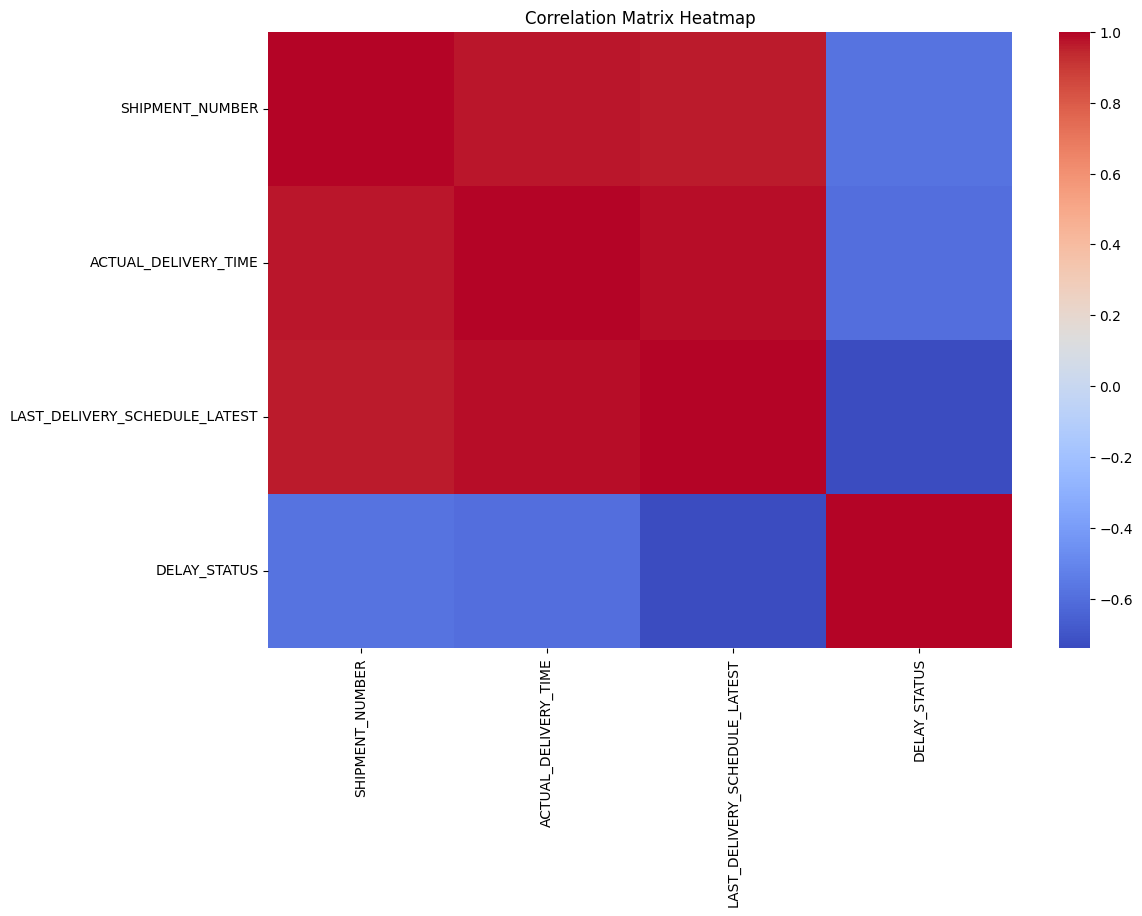

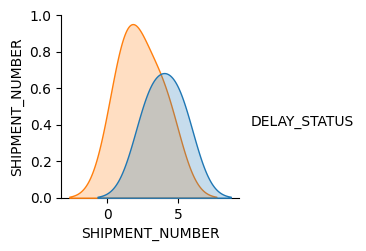

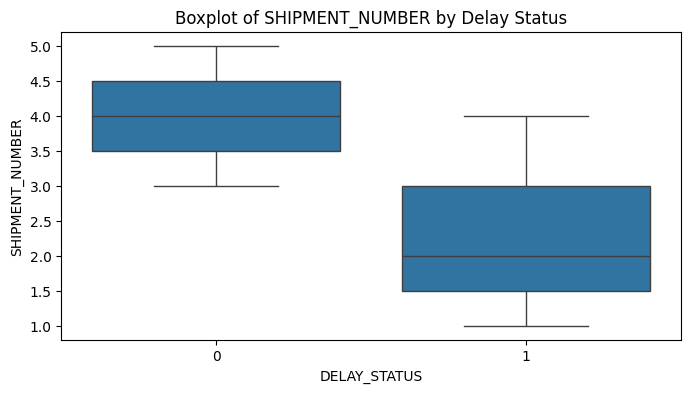

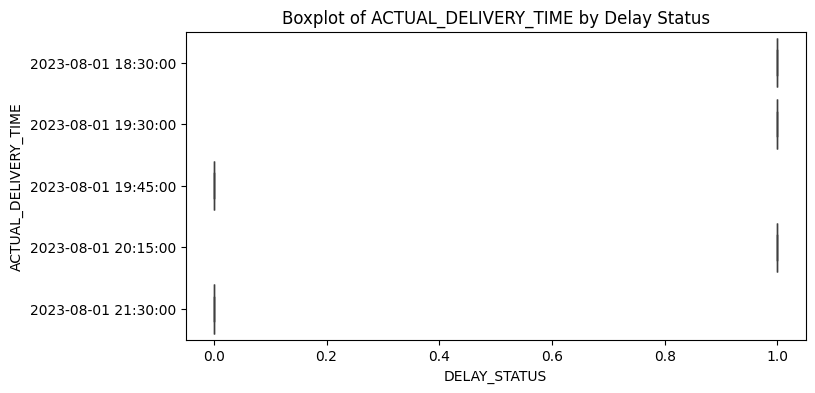

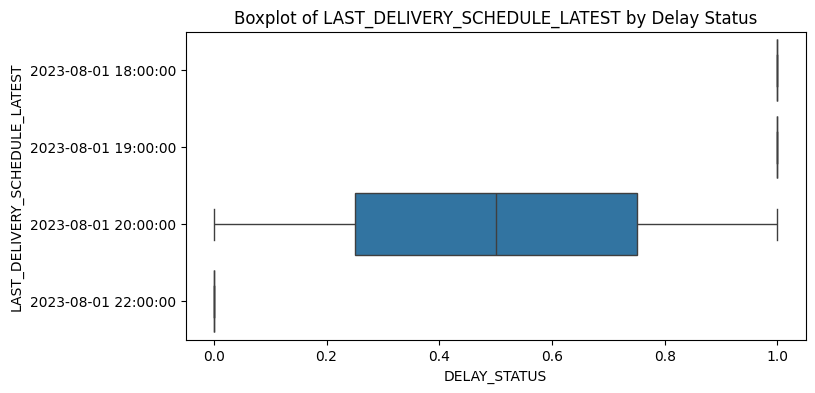

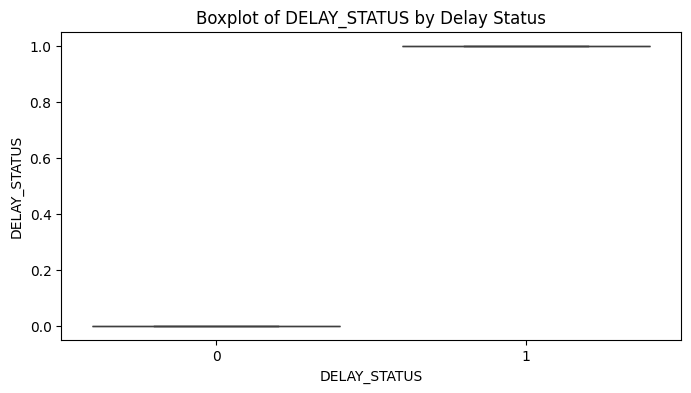

In [6]:
########## 5. Visualisation ##########
import seaborn as sns
import matplotlib.pyplot as plt

# Heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

# Pairplot to visualize relationships between variables
sns.pairplot(shipment_data, hue='DELAY_STATUS')
plt.show()

# Boxplot for each feature by 'DELAY_STATUS'
for column in shipment_data.columns:
    if shipment_data[column].dtype != 'object':
        plt.figure(figsize=(8, 4))
        sns.boxplot(x='DELAY_STATUS', y=column, data=shipment_data)
        plt.title(f'Boxplot of {column} by Delay Status')
        plt.show()

<ipython-input-11-acc06174b608>:39: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  gps_data['RECORD_TIMESTAMP'] = pd.to_datetime(gps_data['RECORD_TIMESTAMP'])


Classification Report:
               precision    recall  f1-score   support

       False       0.64      0.34      0.45       237
        True       0.70      0.89      0.78       410

    accuracy                           0.69       647
   macro avg       0.67      0.62      0.62       647
weighted avg       0.68      0.69      0.66       647

Feature Importances:
                                    Feature  Importance
1                                 DISTANCE    0.063796
0                          DELIVERY_WINDOW    0.039000
5                    VEHICLE_SIZE_3.5T Van    0.028558
3344         CARRIER_DISPLAY_ID_CAUK001047    0.024836
3279         CARRIER_DISPLAY_ID_CAUK000199    0.017025
...                                    ...         ...
2897  SHIPMENT_NUMBER_SEZHUK-231215-274618    0.000000
2898  SHIPMENT_NUMBER_SEZHUK-231215-274622    0.000000
1757  SHIPMENT_NUMBER_SEZHUK-231119-264256    0.000000
1755  SHIPMENT_NUMBER_SEZHUK-231119-264247    0.000000
2525  SHIPMENT_NUMBER_

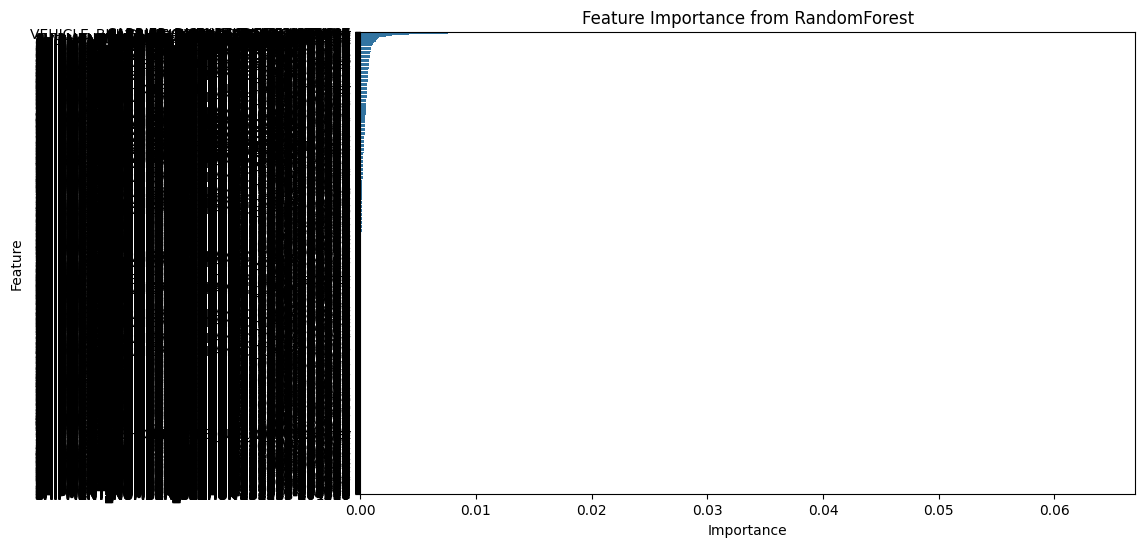

In [11]:
########## 6. Feature Importance using RandomForest #########
import pandas as pd
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import classification_report
import joblib

# Load the datasets
shipment_bookings = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Shipment_bookings.csv')
gps_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/GPS_data.csv')
new_bookings = pd.read_csv('/content/drive/My Drive/Colab Notebooks/New_bookings.csv')

# Haversine function to calculate the distance between two latitude-longitude points
def haversine(lat1, lon1, lat2, lon2):
    from math import radians, cos, sin, sqrt, atan2

    # Radius of the Earth in kilometers
    R = 6371.0

    # Convert latitude and longitude from degrees to radians
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)

    # Haversine formula to calculate the distance
    a = sin(dlat / 2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c

    return distance

# Step 1: Convert relevant columns to datetime format
# This is necessary to perform date-based operations accurately
shipment_bookings['FIRST_COLLECTION_SCHEDULE_EARLIEST'] = pd.to_datetime(shipment_bookings['FIRST_COLLECTION_SCHEDULE_EARLIEST'])
shipment_bookings['FIRST_COLLECTION_SCHEDULE_LATEST'] = pd.to_datetime(shipment_bookings['FIRST_COLLECTION_SCHEDULE_LATEST'])
shipment_bookings['LAST_DELIVERY_SCHEDULE_EARLIEST'] = pd.to_datetime(shipment_bookings['LAST_DELIVERY_SCHEDULE_EARLIEST'])
shipment_bookings['LAST_DELIVERY_SCHEDULE_LATEST'] = pd.to_datetime(shipment_bookings['LAST_DELIVERY_SCHEDULE_LATEST'])
gps_data['RECORD_TIMESTAMP'] = pd.to_datetime(gps_data['RECORD_TIMESTAMP'])

# Filter shipments within the specified time period (October 1, 2023 - December 31, 2023)
start_date = pd.Timestamp("2023-10-1", tz="UTC").replace(microsecond=0)
end_date = pd.Timestamp("2023-12-31", tz="UTC").replace(microsecond=0)
#end_date = start_date - pd.Timedelta(days=90)
filtered_shipments = shipment_bookings[
    (shipment_bookings['LAST_DELIVERY_SCHEDULE_EARLIEST'] >= start_date) &
    (shipment_bookings['LAST_DELIVERY_SCHEDULE_LATEST'] <= end_date)
]

# Merge GPS data with filtered shipments on SHIPMENT_NUMBER
merged_data = pd.merge(filtered_shipments, gps_data, on='SHIPMENT_NUMBER', how='left')

# Determine the actual delivery times by finding the last GPS record for each shipment
actual_delivery_times = merged_data.groupby('SHIPMENT_NUMBER')['RECORD_TIMESTAMP'].max().reset_index()

# Merge actual delivery times back with the filtered shipments
delivery_analysis = pd.merge(filtered_shipments, actual_delivery_times, on='SHIPMENT_NUMBER', how='left')
delivery_analysis.rename(columns={'RECORD_TIMESTAMP': 'ACTUAL_DELIVERY_TIME'}, inplace=True)

# Calculate the on-time delivery status
delivery_analysis['ON_TIME'] = delivery_analysis['ACTUAL_DELIVERY_TIME'] <= (delivery_analysis['LAST_DELIVERY_SCHEDULE_LATEST'] + timedelta(minutes=30))

# Feature Engineering: Calculate delivery window duration and distance
delivery_analysis['DELIVERY_WINDOW'] = (delivery_analysis['LAST_DELIVERY_SCHEDULE_LATEST'] - delivery_analysis['LAST_DELIVERY_SCHEDULE_EARLIEST']).dt.total_seconds() / 3600
delivery_analysis['DISTANCE'] = delivery_analysis.apply(lambda row: haversine(row['FIRST_COLLECTION_LATITUDE'], row['FIRST_COLLECTION_LONGITUDE'], row['LAST_DELIVERY_LATITUDE'], row['LAST_DELIVERY_LONGITUDE']), axis=1)

# Prepare the feature set and target variable
features = ['VEHICLE_SIZE', 'VEHICLE_BUILD_UP', 'DELIVERY_WINDOW', 'DISTANCE', 'SHIPMENT_NUMBER', 'CARRIER_DISPLAY_ID']
Xt = delivery_analysis[features]
y = delivery_analysis['ON_TIME']

# Encode categorical features
Xe = pd.get_dummies(Xt, columns=['VEHICLE_SIZE', 'VEHICLE_BUILD_UP', 'SHIPMENT_NUMBER', 'CARRIER_DISPLAY_ID'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(Xe, y, test_size=0.2, train_size=0.8, random_state=42)

# Train a RandomForestClassifier
#model = RandomForestClassifier(n_estimators=100, random_state=42)
model = RandomForestClassifier(n_estimators = 100,
                           random_state = 42,
                           min_samples_split = 10,
                           max_features = "sqrt",
                           bootstrap = True)

model.fit(X_train, y_train)

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))

# Get feature importances
feature_importances = model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': Xe.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("Feature Importances:\n", importance_df)

# Plotting feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance from RandomForest')
plt.show()

In [13]:
# Summarising the results in a DataFrame for clarity
results_summary = pd.DataFrame({
    'Step': ['Data Cleaning', 'Descriptive Statistics', 'Correlation Analysis', 'Feature Importance Analysis'],
    'Details': [
        'Handled missing values and duplicates; converted date columns.',
        'Generated summary statistics for both numerical and categorical variables.',
        'Calculated correlation matrix; identified features correlated with delay.',
        'Used RandomForest to identify and rank the most important features.'
    ]
})

print("Summary of Exploratory Data Analysis:\n", results_summary)

Summary of Exploratory Data Analysis:
                           Step  \
0                Data Cleaning   
1       Descriptive Statistics   
2         Correlation Analysis   
3  Feature Importance Analysis   

                                             Details  
0  Handled missing values and duplicates; convert...  
1  Generated summary statistics for both numerica...  
2  Calculated correlation matrix; identified feat...  
3  Used RandomForest to identify and rank the mos...  


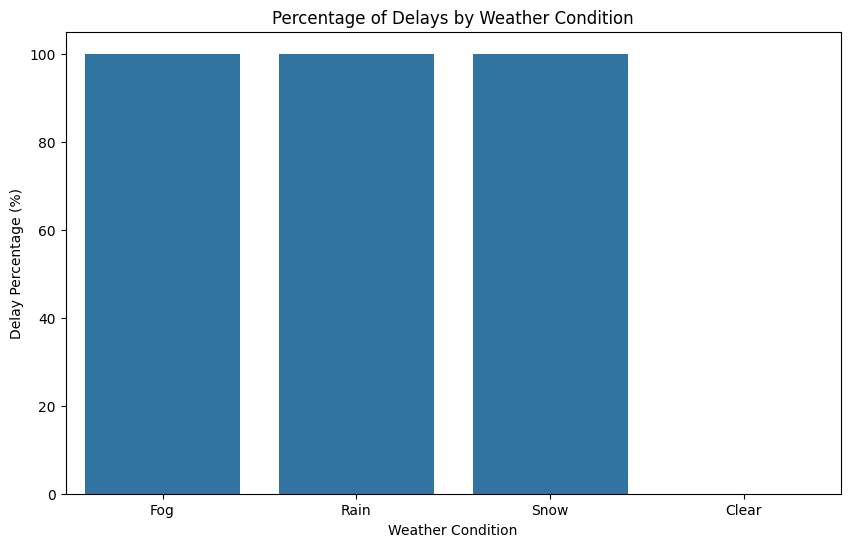

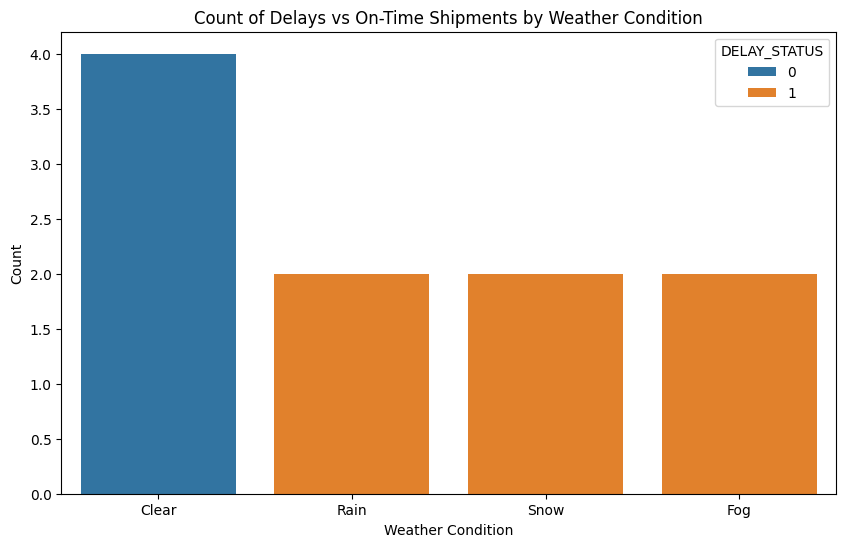

Chi-Square Statistic: 10.0
P-value: 0.01856613546304325


In [6]:
########## Anaysing the impact of weather conditions on shipment delays ##########
########## Data Preparation #######
# Load the dataset and ensuring the necessary columns (WEATHER_CONDITION and DELAY_STATUS) are present.
import pandas as pd

# Sample dataset simulation
data = {
    'WEATHER_CONDITION': ['Clear', 'Rain', 'Clear', 'Snow', 'Clear', 'Rain', 'Fog', 'Clear', 'Snow', 'Fog'],
    'DELAY_STATUS': [0, 1, 0, 1, 0, 1, 1, 0, 1, 1]
}

shipment_data = pd.DataFrame(data)

# Display the first few rows to ensure the dataset is as expected
shipment_data.head()

########## Descriptive Analysis ##########
# Summarise the data to understand the distribution of weather conditions and how often #delays occur.
# Calculate the frequency of each weather condition
weather_distribution = shipment_data['WEATHER_CONDITION'].value_counts()

# Calculate the percentage of delays for each weather condition
delay_by_weather = shipment_data.groupby('WEATHER_CONDITION')['DELAY_STATUS'].mean() * 100

# Combine these two into a single DataFrame for clarity
weather_delay_analysis = pd.DataFrame({
    'Frequency': weather_distribution,
    'Delay_Percentage': delay_by_weather
}).sort_values(by='Delay_Percentage', ascending=False)

# Display the results
weather_delay_analysis

########## Visualisation ##########
## Create visualisations to better understand the relationship between weather conditions and # delays.
import seaborn as sns
import matplotlib.pyplot as plt

# Bar plot to show the frequency of delays by weather condition
plt.figure(figsize=(10, 6))
sns.barplot(x=weather_delay_analysis.index, y=weather_delay_analysis['Delay_Percentage'])
plt.title('Percentage of Delays by Weather Condition')
plt.ylabel('Delay Percentage (%)')
plt.xlabel('Weather Condition')
plt.show()

# Count plot to show the distribution of weather conditions and their associated delay status
plt.figure(figsize=(10, 6))
sns.countplot(x='WEATHER_CONDITION', hue='DELAY_STATUS', data=shipment_data)
plt.title('Count of Delays vs On-Time Shipments by Weather Condition')
plt.ylabel('Count')
plt.xlabel('Weather Condition')
plt.show()

########## Statistical Analysis ##########
# Perform a Chi-Square test to determine if there's a significant association between weather # conditions and delays.
from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = pd.crosstab(shipment_data['WEATHER_CONDITION'], shipment_data['DELAY_STATUS'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Display the results
print(f"Chi-Square Statistic: {chi2}")
print(f"P-value: {p}")

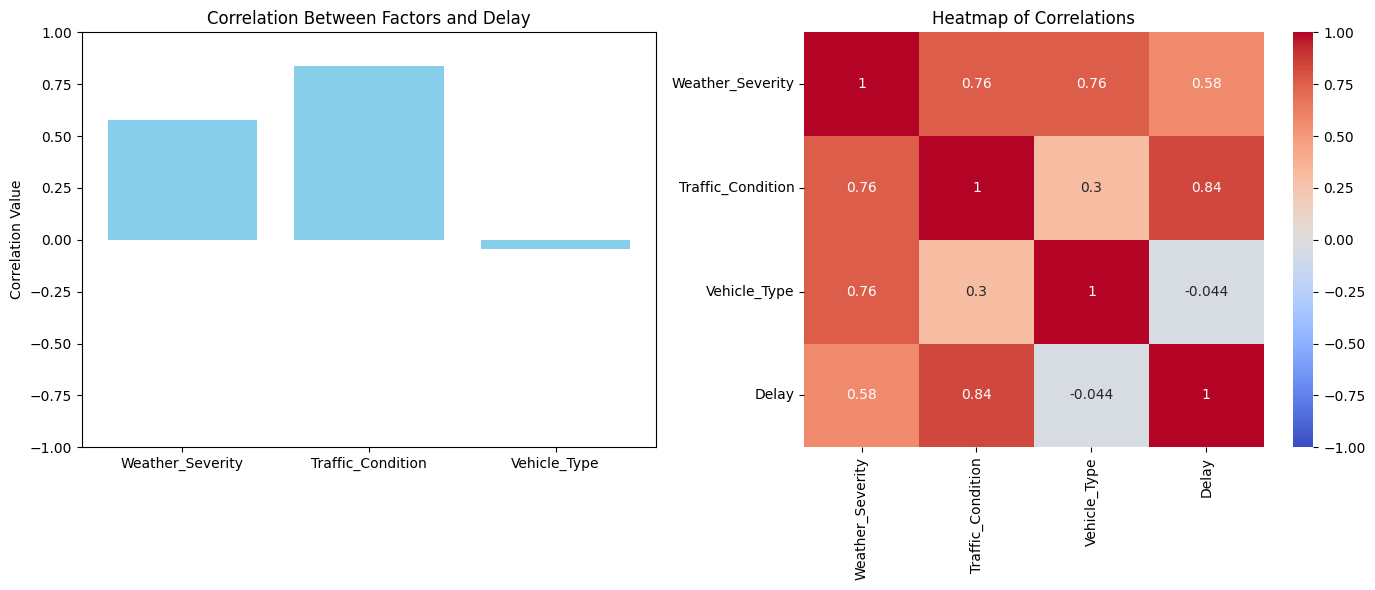

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data to simulate correlation between factors and delays
data = {
    'Weather_Severity': [0.2, 0.3, 0.5, 0.4, 0.6],
    'Traffic_Condition': [0.4, 0.5, 0.7, 0.3, 0.8],
    'Vehicle_Type': [0.3, 0.2, 0.4, 0.6, 0.7],
    'Delay': [0, 1, 1, 0, 1]  # Binary outcome: 1 for delay, 0 for on-time
}

df = pd.DataFrame(data)

# Compute the correlation matrix
corr_matrix = df.corr()

# Plotting side-by-side: Bar chart and heatmap
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Bar chart showing correlation with delay
corr_with_delay = corr_matrix['Delay'].drop('Delay')
axes[0].bar(corr_with_delay.index, corr_with_delay.values, color='skyblue')
axes[0].set_title('Correlation Between Factors and Delay')
axes[0].set_ylabel('Correlation Value')
axes[0].set_ylim(-1, 1)

# Heatmap of the entire correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[1])
axes[1].set_title('Heatmap of Correlations')

# Show the plot
plt.tight_layout()
plt.show()
